In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision.datasets.mnist import FashionMNIST
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import models
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook
import cv2

print(torch.__version__)
device = torch.device('cuda:0')

1.2.0


In [2]:
class Weedread(Dataset):
    def __init__(self, name, transform=None, cl=None):
        hf = h5py.File(name, 'r')
        input_images = np.array(hf.get('data'), np.uint8)
        target_labels = np.array(hf.get('labels')).astype(np.long)
        if(cl == None):
            self.input_images = input_images
            self.target_labels = target_labels
        else:
            family_index = np.where(target_labels[:, 0] == cl)
            self.input_images = input_images[family_index]
            self.target_labels = target_labels[family_index]
            
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        classes = self.target_labels[idx][1]
        family =  self.target_labels[idx][0]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, classes, family
        

class calTech(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('features')) / 255.0
        self.input_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return (self.input_images.shape[0])

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.input_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        return images, labels

In [3]:
INPUT_CHANNEL = 3
BATCH_SIZE = 1
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

classes = [str(i) for i in range(102)]

data_path = os.path.dirname(os.getcwd()) + "/data/calTech/"
Train_data = calTech(data_path + "train.h5", transform=normalize)
Train_dataloader = DataLoader(dataset=Train_data, batch_size = 1, shuffle=True)

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


class My_Model(nn.Module):
    def __init__(self, input_channel=1, num_class=21):
        super(My_Model, self).__init__()
        self.model_ft = models.vgg16(pretrained=True)
        set_parameter_requires_grad(self.model_ft, False) 
        #change FC
        self.model_ft.classifier[6] = nn.Linear(4096, num_class)
        
        #self.family_fc = nn.Linear(num_class, num_family)
        
    
    def forward(self, x):
        # Perform the usual forward pass
        x_class = self.model_ft(x)
            
        return F.softmax(x_class, dim=1)

In [5]:
from torchsummary import summary

_model = My_Model(num_class=102)
_model.to(device)
_model.load_state_dict(torch.load('epochs/VGG16_CalTech.pt'), strict=False)
#summary(_model, input_size=(3, 224, 224))

<All keys matched successfully>

In [6]:
class SaveFeatures():
    """hook function at forward step"""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

def get_final_feature(DataLoader, n):
    
    final_feature_maps = torch.rand([1, n]).to(device)
    _model.eval()
    
    #activations = SaveFeatures((list(_model.model_ft.children())[-1]))
    activations = SaveFeatures(_model.model_ft.classifier[4])
      
    with torch.no_grad():
        correct = 0
        total = 0
        for image, cls in tqdm_notebook(DataLoader):
            image, cls = image.to(device), cls.to(device)
            image = image.float()
            p_classes = _model(image)
            
            predicted = torch.argmax(p_classes, dim=1)
            total += image.size(0)
            correct += (predicted == cls).sum().item()
            
            feature_map = activations.features[0]
            feature_map = feature_map.view(1, n)
            final_feature_maps = torch.cat([final_feature_maps, feature_map])
            
        print('Test Accuracy of the model on the test images: {:.4f} %'.format(100 * correct / total))
            
    activations.close()
    return final_feature_maps[1:]

In [7]:
final_feature_maps = get_final_feature(Train_dataloader, 4096)
print(final_feature_maps.size())

labels = Train_data.input_labels
feaure_maps = final_feature_maps.cpu().numpy()

hf = h5py.File('epochs/feature_maps_VGG_caltech.h5', 'w')
hf.create_dataset('features', data=feaure_maps)
hf.create_dataset('labels', data=labels)
hf.close()


Test Accuracy of the model on the test images: 58.6659 %
torch.Size([9145, 4096])


In [8]:
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def _scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    #sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[0])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),
                            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txt

In [9]:
hf = h5py.File('epochs/feature_maps_VGG_caltech.h5', 'r')
feature_maps = np.array(hf.get('features'))
labels = np.array(hf.get('labels'))

feature_maps = feature_maps[:1000]
labels = labels[:1000]
print(feature_maps.shape)

(1000, 4096)


[0.05600207 0.05091383]


(<Figure size 576x576 with 1 Axes>,
 Text(-1.1683645, -2.1082437, '4'))

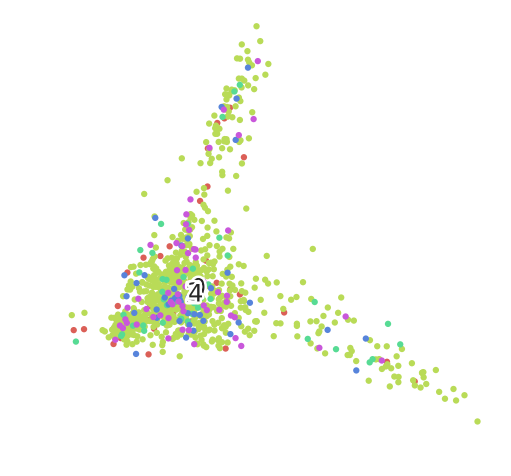

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_maps)
print(pca.explained_variance_ratio_)
_scatter(pca_result, labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 9.517046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.849007
[t-SNE] KL divergence after 300 iterations: 1.084388


(<Figure size 576x576 with 1 Axes>,
 Text(1.1982569, -1.1878793, '4'))

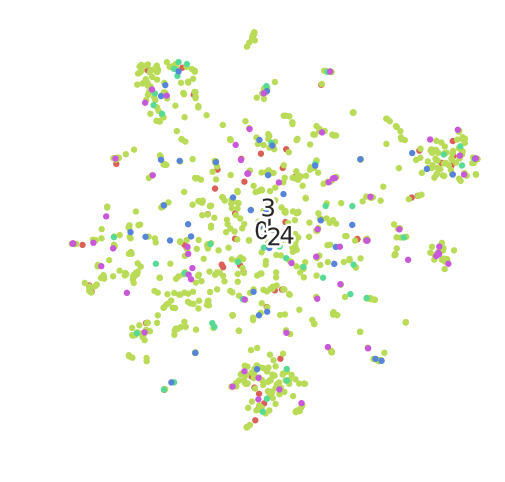

In [11]:
from sklearn.manifold import TSNE

pca = PCA(n_components=100)
pca_result = pca.fit_transform(feature_maps)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(pca_result)
_scatter(tsne, labels)